# Step 1 Establishing route and libraries

In [70]:
# Importing libraries and dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #usado en el paso 3
import plotly_express as px
import seaborn as sns
from scipy import stats as st
from plotly.subplots import make_subplots
df = pd.read_csv("./datasets/games.csv")


# Step 2 Data Processing (Data cleaning, correction and formatting)

2.1 Setting columns to lowercase

In [71]:
df.columns = [column.lower() for column in df.columns]

2.2 Looking for duplicates, incorrect dtypes and nulls.

In [72]:
df.info()
print("_____________________")
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
_____________________


Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Ath this point has been identified missing values in the following columns:
- name
- year_of_Release
- genre
- critic_Score
- user_Score
- rating

Before manipulating each column I will proceed removing duplicated rows if any.

In [73]:
df.duplicated().sum() 

0

Not duplicated rows found. Now let's get back to identify the null values

In [74]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

It looks that name and genre has two atypical values, I'll focus on it

In [75]:
df[df["name"].isnull()]
df[df["year_of_release"].isnull()]
df[df["genre"].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Both elements genre and name are part of the same rows, I'll proceed to delete it because is has not enough relevant information to keep. For the other columns:

- year_of_release column = It's possible to look at the internet for the name of the game and the platform and get the year_of_release, I'll keep it for the moment. (I can look for an API)
- critic_score, user_score, rating = I'll keep it the data with the nan values because I don't have the source where the data was extracted, could be mix it wrongly

In [76]:
df["user_score"].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

The column 'user score' has text and nan values, won't be possible to transform to float if I don't the replace the text for nan values. I'll do it

In [77]:
# Checking before transforming to float
df["user_score"].unique()
df["user_score"] = pd.to_numeric(df["user_score"],errors="coerce")
#df["user_score"].replace(np.nan,-999, inplace=True) #If it is necessary
df["user_score"]= df["user_score"].astype(float)


Now, let's analyze the critic_score column

In [78]:
df["critic_score"].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

It seems right but the decimals are gone, I don't exacly know if the original source mantain the float value or if this is an error. I'll keep it because won't affect the methods that I'm planning to use.

In [79]:
# Checking before transforming to float
df["critic_score"].unique()
# df["critic_score"].replace(np.nan,-999, inplace=True) #If it is necessary
df["critic_score"]= df["critic_score"].astype(float)

Finally the column 'rating' let's check the categories implied.

In [80]:
df["rating"].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

According with the ESRB clasification we can analyze the description of each element with the following table

| Rating            | Description                   |
|-------------------|-----------------------------------|
| Everyone (E)      | Suitable for all ages (formerly KA)         |
| Teens 13+ (T)      | Content suitable for ages 13 and older    |
| Mature 17+ (M)     | Content suitable for mature audiences 17 and older  |
| Everyone 10+ (E10+) | Suitable for ages 10 and older  |
| Kids to Adults (KA) | Suitable for kids and adults (currently Everyone)  |
| Early Childhood (EC) | Suitable for ages 3-6   |
| Adults Only 18+ (+18) | Content suitable for adults 18 and older   |
| Rating Pending    | Rating information pending    |
| Replace K-A with Everyone | Update rating from K-A to Everyone  |


We need to replace Kids to Adults for the current version Everyone

In [81]:
df["rating"].replace('K-A','E',inplace=True)
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

Also, the only classified game in this list with 'AO' is Grand Theft Auto: San Andreas (xbox), when searching on the internet I realized that the actual classification is M (Mature), I'll proceed to change it.

In [82]:
df["rating"].replace('AO','M',inplace=True)
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'EC', 'RP'], dtype=object)

As I can see in the DataFrame info, more than the half of values are missing for the columns critic_score, user_score and rating, however I'll decide to not modified because I don't know the main source of this data, otherwise I could use an API to get it.

In the other hand I can look for the missing years for the specified games, I'll use IGDB database

'''As an extra effort, I connected to the IGDB API (https://www.igdb.com/api) to get the missing years. 
It was necessary to extract the missing values from this list to use it as parameters (game_name and platform)
'''

2.3 Preparing the documentation to the API

I will create a dataframe with the missing years to send the specific names and platform to the API

In [83]:

games_missing_year_df = df[df["year_of_release"].isna()]
filtered_df = games_missing_year_df[["name","platform"]]
filtered_df["platform"].unique() #getting the missing paltforms

array(['PS2', 'Wii', '2600', 'X360', 'GBA', 'PC', 'PS3', 'PS', 'PSP',
       'XB', 'GB', 'DS', 'GC', '3DS', 'N64', 'PSV'], dtype=object)

I manually created this relation table to create a search parameter in the IGDB site.

In [84]:
relation_df = pd.read_csv("datasets/platform_relation.csv") 
fusion = pd.merge(left= filtered_df, right= relation_df, on="platform", how="left")

The dataframe will be exported into a csv file to create a function which will search all the games by platform


In [85]:

def export_to_csv(dataframe):
    '''Save DataFrame in a csv file using with'''
    with open("./datasets/filtered_games_db.csv", 'a', encoding="utf-8", newline="") as f:
        # f.tell() specifies if the file has been executed before
        empty = f.tell() == 0
        # If new, use the headers
        if empty:
            fusion.to_csv(f, index=False, header=True,)
        else:
            # If not, ignore the headers
            fusion.to_csv(f, index=False, header=False)

export_to_csv(fusion)

In case you are interesed to see my script to get the API data, you can clone this repository "https://github.com/Carnivurus/project_6_ice_game_store.git". For now I will show the final processed data received from the API to avoid confusions.

Also it is important to mentionthat IGDB could not find all the games in their database so I proceed to work in another file to have the complete years. Now it's time to merge them.

In [86]:
#This is the info requested and received by the API
processed_df = pd.read_csv("datasets/processed_game_list.csv")

#35 Cases where not identified by the API I did a manual research and save the file into a csv
manually_fill_df = pd.read_csv("datasets/games_not_found.csv")

#Homologating db to concat with the processed_df
manually_fill_df.rename(columns={"game name":"db_name"},inplace=True)
manually_fill_df

processed_df = pd.concat([processed_df, manually_fill_df], ignore_index=True)

Mergin the dabase with the API_database

In [87]:

merged_df = pd.merge(games_missing_year_df, processed_df, left_on=["name","platform"], right_on=["db_name","platform"], how="left")
merged_df["year_of_release"] = merged_df["year"]
d_columns = ["release_date", "game_name", "db_name", "year"]
merged_df.drop(columns=d_columns, inplace=True)
merged_df.head()
# merged_df[merged_df["year_of_release"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1,FIFA Soccer 2004,PS2,2003.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2,LEGO Batman: The Videogame,Wii,2008.0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
3,wwe Smackdown vs. Raw 2006,PS2,2005.0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
4,Space Invaders,2600,1978.0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


I'll keep it for the record but the game Majesty 2: The Fantasy Kingdom Sim was never released. Now I will merge the found values with the main dataframe of this project.

In [88]:
#Passing the values to the current database with the original db
merged_df.shape #269 rows
df.loc[df['year_of_release'].isna(), 'year_of_release'] = merged_df['year_of_release'].values

Once merged and clean the data, I'll proceed to look for the missing values

In [89]:
df.isnull().sum()

name                  2
platform              0
year_of_release       1
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

The analysis makes sense, remember that we have 1 game which never was released. I will delete this entry.

In [93]:
to_delete_index = df[df["year_of_release"].isnull()].index
df.drop(index=to_delete_index, inplace=True)
df["year_of_release"] = df["year_of_release"].astype(int)
df.info()
df["year_of_release"].unique()


<class 'pandas.core.frame.DataFrame'>
Index: 16714 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16714 non-null  object 
 2   year_of_release  16714 non-null  int32  
 3   genre            16712 non-null  object 
 4   na_sales         16714 non-null  float64
 5   eu_sales         16714 non-null  float64
 6   jp_sales         16714 non-null  float64
 7   other_sales      16714 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Now I'll create a new column with the total sales (involving the 3 areas)

In [69]:
df["total_sales"] = df["na_sales"] + df["eu_sales"] + df["jp_sales"] + df["other_sales"]
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


# Step 3 Analyzing the data

### 3.1 Games launched by year

In [94]:
games_by_year_df = df.groupby(by="year_of_release")["name"].count().reset_index()

The code below has been disabled because I found easier/quicker way using use plotly express for the presentation of this project

In [79]:
# plt.bar(games_by_year_df["year_of_release"],height=games_by_year_df["name"])
# plt.show()
# plt.hist(x=df["year_of_release"], bins=20)
# plt.show()

In [80]:

fig1 = px.line(df,x=games_by_year_df["year_of_release"],y=games_by_year_df["name"], color_discrete_sequence=["purple"] , title='Released Games by Year (All regions)')
fig1.update_layout(xaxis_title = 'Years' , yaxis_title= 'Count of games')


The bar char above show us that the majority of the games were launched between 2002 to 2011, being 2008 and 2009 the best years for releases. Despite of the continous increments per year, we had a decline since 2010 to 2016.

In [81]:
fig2 = px.histogram(df,x="year_of_release", title="Released Games by Year (All regions)", nbins=10)
fig2.update_layout(xaxis_title = 'Year of Release' , yaxis_title= 'Count of games')
fig2.show()

As a complement for the previous graph, we can see the distribuition of the frequency of released games in periods of five years. We had 6,088 game released in 2005-2009, in the other hand for the period 2010-2014 we just reach 4,253 released games. Finally for the current data of 2015-2016 we are just seeing 1,115 released games, expecting to continue the decline in released games for this period

### 3.2 Sales by platform

In [82]:
top_sales_df = df.pivot_table("total_sales",index="platform", aggfunc="sum").reset_index().sort_values(by="total_sales",ascending=False).head(10)
top_sales_df

,platform,total_sales
16,PS2,1255.77
28,X360,971.39
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


The table shown above shows the platforms with the highest number of sales, being Playstation 2 the most successful, raising 1,255 million of dolars

In [83]:
fig3 = px.bar(top_sales_df,x="platform",y="total_sales", color="platform" ,color_discrete_sequence=px.colors.qualitative.Set3 , title='Top Platforms in Game Sales')
fig3.update_layout(xaxis_title = 'Platform', yaxis_title= 'Total Sales')
fig3.show()

We can see a clear difference y sales, we will focus on the main 6 (above 600 millions of sales) to analize the tendence

### 3.3 Platform Game Sales by Year

In [84]:
filter = top_sales_df["platform"].head(6).values
top6_sales_df= df[df["platform"].isin(filter)]
grouped_top_sales = top6_sales_df.groupby(by=["platform","year_of_release"])['total_sales'].sum().reset_index()

In [85]:
fig4 = px.bar(grouped_top_sales,x="year_of_release", y="total_sales", color="platform", color_discrete_sequence=px.colors.qualitative.Set3, title='Platform Game Sales by Year')
fig4.update_layout(xaxis_title='Years of Release', yaxis_title='Total Sales')
fig4.show()
# px.line(grouped_top_sales,x="year_of_release", y="total_sales", color="platform", color_discrete_sequence=px.colors.qualitative.Set3)

In this chart we can see interesting information about the tendence, PS2 and Xbox 360 lead the market in Sales, PS2 remain in the market for 11 years, while Xbox has present for 12 years (and counting). 

The average in the market presence is around 9 years while the peak of increasing sales is 5.5 years.

It will depend on the strategy of each company to mantain the console or provide a new generation


### 3.4 Profits by game

When trying to represent the data in a boxplot we can see atypical values which are affecting the graph to show correctly all the parameters. I represent all the values on the left to have an idea of who the look

Note: pyplot express has not the capacity of ignore the outlier, the documentation use points with the parameters 'all', 'False' but they just extend the whiskers


In [86]:

# test = px.box(top6_sales_df,'platform','total_sales', color="platform", points='all', title="Game Sales by Platform")
# test = px.box(top6_sales_df,'platform','total_sales', color="platform", points=False) #Just extends the whiskers

newdf = top6_sales_df[["platform",'total_sales']]


In [87]:
top6_sales_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16700,Mezase!! Tsuri Master DS,DS,2009,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


To have a better understating we can follow the next graph where the oultiers where hide to expand the visualization of Q1, median and Q3

[]

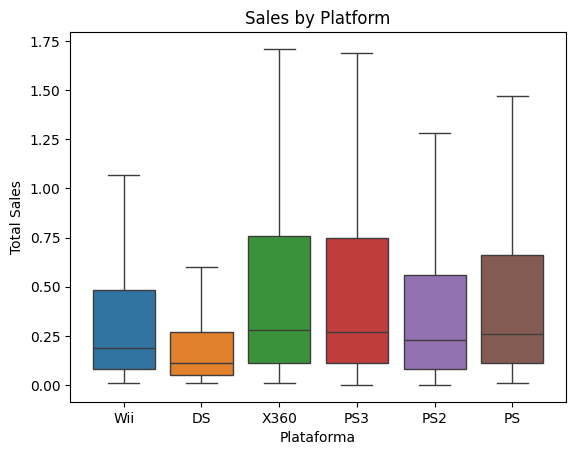

In [88]:
fig5 = sns.boxplot(top6_sales_df,x='platform',y='total_sales', showfliers=False, hue="platform")
fig5.set_title('Sales by Platform')
fig5.set_xlabel('Plataforma')
fig5.set_ylabel('Total Sales')
fig5.plot()

Talking about average, the nintendo DS got the fewest profits per game with a mean of $110,000 dollars, meanwhile Xbox and PS3 had a similar profits with $280,000 and $270,000 (per game) correspondingly. 
Despite that PS2 lead the sales market, the average profits per game were of $230,000 dollars, it interesting to know more about how they lead the market (maybe specific games which where the hits in those years).

### 3.5 User and Critic Reviews

Now it's time to see how the critics can impact a game, we will get two graphs, one related to the critic score and the other focused on the user score.

In [89]:
critics_df = df.groupby(by='critic_score')["total_sales"].sum().reset_index()
# px.bar(critics_df,x="critic_score",y='total_sales') #Another option
fig6 = px.scatter(critics_df,x="critic_score",y='total_sales', title='Sales Impacted by critic Score')
fig6.update_layout(xaxis_title='Critic Score', yaxis_title='Total Sales')
fig6.show()
corr= df['critic_score'].corr(df["total_sales"])
print(f'La correlación de critic score y sales score es de {corr}')

La correlación de critic score y sales score es de 0.2455066871773633


As we can see in the table the is just a light positive correlation between the critic score and the sales of games.

Now let's check the user score

In [90]:
# Reviews y ventas. 
user_critics_df = df.groupby(by='user_score')["total_sales"].sum().reset_index()
fig7 = px.scatter(user_critics_df,x="user_score",y='total_sales')
fig7.update_layout(xaxis_title='User Score', yaxis_title='Total Sales')
fig7.show()
corr2= df['user_score'].corr(df["total_sales"])
print(f'La correlación de user score y sales score es de {corr2}')

La correlación de user score y sales score es de 0.0881791198757913


The result is similar, we have a light positive correlation between the user score and the total sales.

Could it be possible that scores up to 8 are biased by bought critics? Let's check it

In [91]:
sample = df[df["user_score"]<8]
corr3 = sample['user_score'].corr(sample["total_sales"])

print(f'La correlación del testeo es {corr3}')

La correlación del testeo es 0.07014099293272845


No, it looks there is no real correlation between sales and critics

### 3.6 Top 10 games released in different platforms

In [92]:

filtered_games = df.groupby(by=['name','platform'])['total_sales'].sum().reset_index()

duplicated_games_list = df[df['name'].duplicated()].sort_values(by='total_sales', ascending=False)
duplicated_games_list = duplicated_games_list['name'].values

duplicated_games_df = df[df['name'].isin(duplicated_games_list)]
duplicated_games_df = duplicated_games_df.sort_values(by='total_sales', ascending=False)

top_10_games_dp = duplicated_games_df.head(10)
top_10_games_dp_list = top_10_games_dp['name'].values
top_10_games_dp_list

games_different_platforms = df[df['name'].isin(top_10_games_dp_list)]


games_different_platforms

fig8 = px.bar(games_different_platforms, x='name', y='total_sales', color='platform', title='Top 10 games in history')
fig8.update_layout(xaxis_title='Game Name', yaxis_title='Total Sales (millions)')
fig8.show()


- Mario bros has a lot of pressence
- Tetris third party in the 1984 and 1989
- Grand thef auto, most successful game in cross platform up to 2016
- Grand Thef Auto Saga and Super Mario and Call of Duty.

### 3.7 Top Genres

Write introduction

In [93]:
genre_df =df.groupby(by='genre')['total_sales'].sum().reset_index()
genre_df = genre_df.sort_values('total_sales', ascending=True)
genre_df

,genre,total_sales
11,Strategy,174.23
1,Adventure,237.59
5,Puzzle,242.57
9,Simulation,389.94
2,Fighting,447.53
6,Racing,728.67
3,Misc,802.51
4,Platform,827.77
7,Role-Playing,934.56
8,Shooter,1052.45


In [94]:
fig9 = px.bar(genre_df, x='total_sales',y='genre', title='Top Videogames Genres (Global)')
fig9.update_layout(xaxis_title='Total Sales', yaxis_title='Genres')
fig9.show()

Action the most sold genre
Sport the second most sold genre
Less sold is Strategy


# Step 4 Profiles by Region

### Top 5 platforms by region

In [95]:
regions = ['na_sales', 'eu_sales' ,'jp_sales']
platforms_df = df.groupby(by='platform')[regions].sum().reset_index()
platforms_na = platforms_df.sort_values(by='na_sales', ascending=False).head(5)
platforms_eu = platforms_df.sort_values(by='eu_sales', ascending=False).head(5)
platforms_jp = platforms_df.sort_values(by='jp_sales', ascending=False).head(5)


In [96]:
from plotly.subplots import make_subplots

fig10 = make_subplots(rows=1, cols=3, subplot_titles=['NA Sales', 'EU Sales', 'JP Sales'])

fig10.add_trace(px.bar(platforms_na.head(5), x='platform', y='na_sales').data[0],row=1, col=1)
fig10.add_trace(px.bar(platforms_eu.head(5), x='platform', y='eu_sales').data[0],row=1, col=2)
fig10.add_trace(px.bar(platforms_jp.head(5), x='platform', y='jp_sales').data[0],row=1, col=3)

fig10.update_layout(title_text='Top 5 platforms')
fig10.show()

We have a representation of the top 5 platforms for each market.It is import to highlight that each region has different preferences talking about consoles.
As a brief, Xbox was created in United States, while Playstation and Nintendo consoles were created in Japan, it make sense when we analize it. The top console in sale games was Xbox360 while in Japan xbox is not part of the top 5 (being Nintendo the top console in this region). Europe is in the middle of this, and the data shows that Playstation y the favorite console for them, it looks that each company (Xbox, Nintendo, Playstation) has strategies to be positioned in each market.

The only console who is part of the top 5 of all the markets is the PS2.


In [97]:
fig11 = px.bar(platforms_na.head(5), x='platform', y=regions, barmode='group')
fig11.show()

It is time to talk about the sales in each market. It is easy to see that North America lead the three regions in sold games by platform, This make sense when we start thinking about the population in each region. Let's highlight this comment with the table below.

| Region|Population in millions (2016)|
|-------------|-------------|
|* North America| 565 |
|* Europe| 510 |
|* Japan| 127 |

According to the population described above it was easier to North America to reach that numbers because they are 4 times bigger than Japan. In the other hand, Europe had not so big difference between their population with North America (55 millions of difference) but they got less sales. It will be interesting to think in which factor could be affecting this sales.

*Estimated data

### Top 5 genres by region

North America Region

In [98]:
regions = ['na_sales', 'eu_sales' ,'jp_sales']
genre_df =df.groupby(by='genre')[regions].sum().reset_index()
genre_na_df = genre_df[['genre','na_sales']].sort_values(by='na_sales', ascending=False)
genre_na_df.head(5)

,genre,na_sales
0,Action,879.01
10,Sports,684.43
8,Shooter,592.24
4,Platform,445.50
3,Misc,407.27


Europe Region

In [99]:
genre_eu_df = genre_df[['genre','eu_sales']].sort_values(by='eu_sales', ascending=False)
genre_eu_df.head(5)

,genre,eu_sales
0,Action,519.13
10,Sports,376.79
8,Shooter,317.34
6,Racing,236.51
3,Misc,212.74


Japan Region

In [100]:
genre_jp_df = genre_df[['genre','jp_sales']].sort_values(by='jp_sales', ascending=False)
genre_jp_df.head(5)

,genre,jp_sales
7,Role-Playing,355.41
0,Action,161.43
10,Sports,135.54
4,Platform,130.83
3,Misc,108.11


In [101]:
genre_bar_df = genre_df.sort_values(by='na_sales', ascending=False)

fig11 = px.bar(genre_bar_df,'genre',regions, barmode='group')
fig11.update_layout(xaxis_title='Genre', yaxis_title='Games Count')
fig11.show()
genre_df

,genre,na_sales,eu_sales,jp_sales
0,Action,879.01,519.13,161.43
1,Adventure,105.26,63.54,52.30
2,Fighting,223.36,100.33,87.48
3,Misc,407.27,212.74,108.11
4,Platform,445.50,200.35,130.83
5,Puzzle,122.87,50.01,57.31
6,Racing,359.35,236.51,56.71
7,Role-Playing,330.81,188.71,355.41
8,Shooter,592.24,317.34,38.76
9,Simulation,181.89,113.52,63.80


For North America and Europe region we can see a similar behaviours in the top 5 genres. Action genres are the most demanded followed by Sports and shooters, the 4th place has a little difference being 'platform games' more required in NA while 'racing games' have more presence in Europe.

Japan has more demand on Role-Playing games, followed by action, sports platform and misc genres.

### ESRB Classification

In [102]:
rating_df = df.groupby(by='rating')[regions].sum().reset_index()
rating_df.sort_values(by='na_sales', ascending=False)

,rating,na_sales,eu_sales,jp_sales
0,E,1295.55,710.52,199.57
5,T,759.75,427.03,151.40
3,M,749.74,484.58,64.24
1,E10+,353.32,188.52,40.20
2,EC,1.53,0.11,0.00
4,RP,0.00,0.08,0.00


With this table we can see that the best selling games are the ones who are classified to 'Everyone' followed by 'Teens' and 'Mature Only (+18) for North America and Japan. In Europe we have an slighty difference switching places the categories 'Mature' (for the second place) and 'Teen' (for the third).

So, ¿The clasification may affect the sales in individual regions? The answer is, Yes! However is more complicated that we think. A singular game can be classified to different targets depending of the system applied in their countries. ESRB applies their classification to the games in North America, however Euorpe uses PEGI (Pan European Game Information), so, as an example: Grand Thef Auto could be classified in North America for Mature (18+) and for PEGI coul classified the same game as 16 (16+). The sales will be affected just for this classification.

| Rating            | Description                   |
|-------------------|-----------------------------------|
| Everyone (E)      | Suitable for all ages (formerly KA)         |
| Teens 13+ (T)      | Content suitable for ages 13 and older    |
| Mature 17+ (M)     | Content suitable for mature audiences 17 and older  |
| Everyone 10+ (E10+) | Suitable for ages 10 and older  |
| Kids to Adults (KA) | Suitable for kids and adults (currently Everyone)  |
| Early Childhood (EC) | Suitable for ages 3-6   |
| Adults Only 18+ (+18) | Content suitable for adults 18 and older   |
| Rating Pending    | Rating information pending    |
| Replace K-A with Everyone | Update rating from K-A to Everyone  |


# Paso 5. Hipotesis

#### 5.1 The average user score for the platforms Xbox One and PC are the Same

- H<sub>0</sub> = The average score between Xbox One and Pc is `not different`
- H<sub>1</sub> = The average score between Xbox One and Pc is `different`

In [153]:
user_score_xone_filter = df.query('platform =="XOne" and user_score.notna()')['user_score']
user_score_pc_filter = df.query('platform =="PC" and user_score.notna()')['user_score']

# len(user_score_xone_filter) #182 values
# len(user_score_pc_filter) #770 values

In order to define the parameter `equal_var=` for the method `st.ttest_ind()` I will check the variation for each one

In [154]:
print(np.var(user_score_xone_filter), np.var(user_score_pc_filter))

1.8965188383045526 2.3377471580367684


The variances are different, let's proceed with the proper setup

In [155]:
alpha= 0.05
t_statistic, p_value = st.ttest_ind(user_score_xone_filter,user_score_pc_filter,equal_var=False)

print(p_value)

if p_value<alpha:
    print('H0 is rejected')
else:
    print('H0 cannot be rejected')


4.935072360183574e-06
H0 is rejected


Conclusion: `We reject` the null hypothesis 'The average user score for the platforms Xbox One and PC are the Same'

5.2 The average user score for the platforms Xbox One and PC are the Same
 Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

#### 5.2 The average user score for the genres action and sports are different

- H<sub>0</sub> = The average score between action and sport `is not different`
- H<sub>1</sub> = The average score between action and sport `is different`

In [160]:
user_score_action = df.query('genre =="Action" and user_score.notna()')['user_score']
user_score_sports = df.query('genre =="Sports" and user_score.notna()')['user_score']

# print((len(user_score_action),len(user_score_sports)))
# print(np.var(user_score_action), np.var(user_score_sports))

alpha= 0.05
t_statistic, p_value = st.ttest_ind(user_score_action,user_score_sports,equal_var=False)

print(p_value)

if p_value<alpha:
    print('H0 is rejected')
else:
    print('H0 cannot be rejected')


0.11483818791498286
H0 cannot be rejected


Conclusion: `We cannot` reject the hypothesis: 'The average score between action and sport `is not different`'

## Final conclusions: